todo: 
1. + попробовать пулинг по каналам
2. попробовать увеличить алфавит добавить е и т
3. чекнуть как свитается цер

In [1]:
import librosa
import librosa.display
import scipy.io.wavfile
import sklearn
import tensorflow as tf
import numpy as np
from config import SEQ_LENGTH, FRAMERATE, CHUNK, FFT_SIZE
import matplotlib.pyplot as plt
import generate_wav_samples as gen
import os
import keras
import itertools
from config import MORSE_CHR
from tqdm import tqdm

from keras import backend as K
from keras import regularizers
from keras.layers.convolutional import Conv2D, MaxPooling2D, Conv1D, MaxPooling1D
from keras.layers import Input, Dense, Activation,TimeDistributed, GlobalMaxPooling1D
from keras.layers import Reshape, Lambda, Dropout, Bidirectional, Permute
from keras.layers.merge import add, concatenate
from keras.models import Model
from keras.layers.recurrent import GRU, SimpleRNN,LSTM
from keras.optimizers import SGD, Adam, RMSprop
from keras.utils.data_utils import get_file
from keras.preprocessing import image
import keras.callbacks
import pickle
import Levenshtein
import string
import pandas as pd

import generator_test as gt


Using TensorFlow backend.


In [2]:
OUTPUT_DIR = 'rnn_output'

In [3]:
class VizCallback(keras.callbacks.Callback):
    def __init__(self, run_name, test_func, X):
        self.test_func = test_func
        self.output_dir = os.path.join(
            OUTPUT_DIR, run_name)
        self.X = X

    def show_edit_distance(self, num):
        print('edit distance: ', num)
        """
        num_left = num
        mean_norm_ed = 0.0
        mean_ed = 0.0
        while num_left > 0:
            word_batch = next(self.text_img_gen)[0]
            num_proc = min(word_batch['the_input'].shape[0], num_left)
            decoded_res = decode_batch(self.test_func,
                                       word_batch['the_input'][0:num_proc])
            for j in range(num_proc):
                edit_dist = editdistance.eval(decoded_res[j],
                                              word_batch['source_str'][j])
                mean_ed += float(edit_dist)
                mean_norm_ed += float(edit_dist) / len(word_batch['source_str'][j])
            num_left -= num_proc
        mean_norm_ed = mean_norm_ed / num
        mean_ed = mean_ed / num
        print('\nOut of %d samples:  Mean edit distance:'
              '%.3f Mean normalized edit distance: %0.3f'
              % (num, mean_ed, mean_norm_ed))
        """

    def on_epoch_end(self, epoch, logs={}):
        self.model.save_weights(os.path.join(self.output_dir, 'weights%02d.h5' % (epoch)))
        
        #self.show_edit_distance(256)
        
        dec_len = 10
        for i in range(dec_len):
            labels = self.X[1][i:i+1]
            print('labels: ', labels_to_text([int(e) for e in labels[0]]))
        
        word_batch = self.X[0][:dec_len]
        res = decode_batch(self.test_func, word_batch)
        print('result lens: ', len(res))
        for e in res[:dec_len]:
            print(e)
        
        len_for_cer_count = 5000
        word_batch = self.X[0][:len_for_cer_count]
        res = decode_batch(self.test_func, word_batch)
        print()
        
        cers = []
        for i, t in enumerate(self.X[1][:len_for_cer_count]):
            true = labels_to_text(t)
            pred = res[i]

            c = cer(true, pred)

            cers.append(c)

        print(np.mean(cers))
            
def cer(true, pred):
    t = ''.join(true).strip()
    p = ''.join(pred).strip()
    distance = Levenshtein.distance(t, p)
    return distance / len(t) if len(t) > 0 else len(p)

def ctc_lambda_func(args):
    y_pred, labels, input_length, label_length = args
    bc = K.ctc_batch_cost(labels, y_pred, input_length, label_length)
    return bc

'''
def cer(true, pred):
    t = ''.join(true).strip()
    p = ''.join(pred).strip()
    distance = Levenshtein.distance(t, p)
    return distance / len(t)
'''

def labels_to_text(i):
    return [MORSE_CHR[e] for e in i]

def decode_batch2(test_func, word_batch):
    out = test_func([word_batch])[0]
    ret = []
    print(np.argmax(out, axis = -1))
    return np.argmax(out, axis = -1)


def decode_batch(test_func, word_batch):
    out = test_func([word_batch])[0]
    r = np.argmax(out, axis=-1)
    #print('r: ', r)
    
    res = []
    for a in r:
        sub_res = []
        for i, e in enumerate(a):
            #print(i, e)
            if i == 0:
                sub_res.append(e)
                continue
            if (e == a[i-1]):
                continue
            if (e == len(MORSE_CHR) - 1):
                continue
            sub_res.append(e)
            
        sub_res = [e for e in sub_res if e != len(MORSE_CHR) - 1]
        sub_res = labels_to_text(sub_res)
        res.append(sub_res)
            
    #[e if (i==0 or c != bc[i-1] and c!=3)]
    #print('res: ', res)
    return res



In [4]:
sample_len = SEQ_LENGTH

samples_count = 100000
sr = 8000
dict_len = len(MORSE_CHR)
max_seq_len = 5
mel_count = 1
mel_len = 161

In [5]:
dg = gen.DataGenerator()
g = dg.seq_generator(SEQ_LENGTH, FRAMERATE, 1, sr, mel_count)

In [6]:
def read_data(set_len, g):
    l = np.zeros([set_len, max_seq_len], dtype=np.int32)
    X = np.zeros([set_len,  mel_len, mel_count])
    input_length = np.zeros([set_len, 1], dtype=np.int32)
    label_length = np.zeros([set_len, 1], dtype=np.int32)

    i = 0
    for wave, label_indexes, labels, c, mel in tqdm(g):        
        if len(labels) > max_seq_len:
            continue
        
        X[i, :, :] = mel
        
        l[i, :len(labels)] = labels
        input_length[i, :] = mel.shape[0]
        
        label_length[i, :1] = c
        
        i+=1
        if i == set_len:
            break
        
    return [X, l, input_length, label_length], l

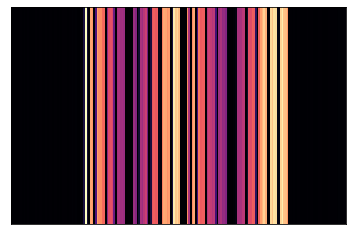

In [7]:
import scipy
from numpy.lib.stride_tricks import as_strided

def rolling_window(a, window):
    shape = a.shape[:-1] + (a.shape[-1] - window + 1, window)
    strides = a.strides + (a.strides[-1],)
    return np.lib.stride_tricks.as_strided(a, shape=shape, strides=strides)


wave, sr = librosa.core.load('/home/user/Dropbox/projs/MorseNet/generated/0.wav', sr=8000)
#wave, sr = librosa.core.load('/home/user/Downloads/websdr_recording_start_2019-06-15T21_33_35Z_7017.3kHz.wav', sr=8000)


#wave = wave[:33000]
#wave = wave.reshape(SEQ_LENGTH)
wave = librosa.util.normalize(wave)
mel = librosa.feature.melspectrogram(wave, sr=sr, n_fft=250, n_mels=1, hop_length=200, power=2)
#mel = np.where(mel<0.1, 0, mel)

#print(mel)
def smooth(mel, w):
    for i in range(mel.shape[0]):
        print(mel.shape[1] // w)
        steps = mel.shape[1] // w
        for j in range(steps):
            if (j+1)*w > mel.shape[1]:
                continue

            window = mel[i, j*w:(j+1)*w]
            #print(window)

            window = window / np.linalg.norm(window)
            #print(window)
            #print(np.linalg.norm(window))


            #window = window / np.max(window)

            #print(window)

            #window = np.normalize(window)
            mel[i, j*w:(j+1)*w] = window
    return mel
#mel = smooth(mel, 30)
#mel = smooth(mel, 40)

#mel = rolling_window(mel, 160).max(axis=1)
#print(mel)

#mel = scipy.ndimage.filters.maximum_filter1d(mel, 2)
#mel = np.max(mel) 
#mel = np.where(mel<1, 0, mel)
#mel = np.where(mel>1, 1, mel)
#to_pred = np.zeros([1,  mel_len, mel_count])
#to_pred[0,:,:] = mel

#print(decode_batch(get_all_layer_outputs, to_pred))

plt.figure()
#fig, ax = plt.subplots(1, sharex=True, figsize=(50,100))
#plt.subplot(figsize=(50,100))
librosa.display.specshow(mel, sr=8000)
plt.show()

In [8]:
if False:
    X, l = gt.read_data(samples_count, g)

In [9]:
dataset = 'dataset_100k_digits_te.pickle'#'dataset_100k_digits.pickle'

In [10]:
if False:
    with open(dataset, 'wb') as f:
        pickle.dump([X, l], f)

In [11]:
if True:
    with open(dataset, 'rb') as f:
        X, l = pickle.load(f)

In [12]:
(X[0].size * X[0].itemsize)

128800000

In [13]:
X_val, l_val = read_data(200, g)

255it [00:03, 83.26it/s] 


In [14]:
conv_filters = 64
kernel_size = 16
pool_size = 32
time_dense_size = 32
rnn_size = 32
minibatch_size = 32

In [15]:
import keras.backend as K

def channelPool(x):
    return K.max(x,axis=-1)


def get_model(optimizer):
    input_shape = (mel_len, mel_count)

    act = 'relu'
    input_data = Input(name='the_input', shape=input_shape, dtype='float32')
    
    prev = None
    for i in range(2):
        conv = Conv1D(conv_filters, kernel_size, strides = 1, padding='same', 
                       activation=act, kernel_initializer='he_normal',
                       name=f'conv_{i}')(input_data if prev is None else prev)
        

        
        #pm1 = Permute((2, 1))(inner)
        #mp = MaxPooling1D(pool_size=pool_size, name=f'max_{i}', strides=2, padding='same', )(pm1)
        #pm2 = Permute((2, 1))(mp)
        #mp = MaxPooling1D(pool_size=pool_size, name=f'max_{i}', strides=1, padding='same', )(inner)
        #ll = Lambda(channelPool)(inner)#, output_shape=optionalInTensorflow
        prev = conv
    
    conv10 = Conv1D(4, 16, padding='same', 
               activation=act, kernel_initializer='he_normal',
               name=f'conv_10')(input_data)
    
    conv11 = Conv1D(6, 16, padding='same', 
           activation=act, kernel_initializer='he_normal',
           name=f'conv_11')(conv10)
    
    conv12 = Conv1D(8, 32, padding='same', 
       activation=act, kernel_initializer='he_normal',
       name=f'conv_12')(conv11)
    
    conv13 = Conv1D(4, 16, padding='same', 
       activation=act, kernel_initializer='he_normal',
       name=f'conv_13')(conv12)
        
    conv2 = Conv1D(1, 16, padding='same', 
               activation=act, kernel_initializer='he_normal',
               name=f'conv_2_{i}')(prev)
    
    #gru2 = GRU(rnn_size, return_sequences=True, kernel_initializer='he_normal', name='gru2')(mp)
    #gru = GRU(32, return_sequences=True, kernel_initializer='he_normal', name='gru1',unroll=True)(mp)
    #dense0 = Dense(16, kernel_initializer='he_normal', name='dense0')(mp)
    
    srnn = SimpleRNN(64, return_sequences=True, kernel_initializer='he_normal')(conv13)
    #srnn2 = SimpleRNN(32, return_sequences=True, kernel_initializer='he_normal',)(srnn)
    #srnn3 = SimpleRNN(32, return_sequences=True, kernel_initializer='he_normal',)(srnn2)
    
    
    #lstm = LSTM(32, return_sequences=True, kernel_initializer='he_normal', name='lstm',unroll=True)(mp)
    #lstm2 = LSTM(rnn_size, return_sequences=True, kernel_initializer='he_normal', name='lstm2')(lstm)
    
    #lstm2 = LSTM(rnn_size, return_sequences=True, kernel_initializer='he_normal', name='lstm2')(lstm)
    #lstm3 = LSTM(rnn_size, return_sequences=True, kernel_initializer='he_normal', name='lstm3')(lstm2)

    #dense2 = Dense(128, kernel_initializer='he_normal', name='dense2')(gru)

    #dpo = Dropout(0.01, name='do1')(gru)
    dense1 = Dense(dict_len, kernel_initializer='he_normal', name='dense1')(srnn)

    y_pred = Activation('softmax', name='softmax')(dense1)

    Model(inputs=input_data, outputs=y_pred).summary()

    labels = Input(name='the_labels', shape=[max_seq_len], dtype='float32')
    input_length = Input(name='input_length', shape=[1], dtype='int64')
    label_length = Input(name='label_length', shape=[1], dtype='int64')

    print(y_pred, labels, input_length, label_length)

    loss_out = Lambda(
        ctc_lambda_func, output_shape=(1,),
        name='ctc')([y_pred, labels, input_length, label_length])

    # clipnorm seems to speeds up convergence
    model = Model(inputs=[input_data, labels, input_length, label_length], outputs=loss_out)

    model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer=optimizer)

    test_func = K.function([input_data], [y_pred])
    viz_cb = VizCallback('test', test_func, X_val)
    
    return model, viz_cb


In [16]:
model, viz_cb = get_model(RMSprop(lr=0.005))




_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, 161, 1)            0         
_________________________________________________________________
conv_10 (Conv1D)             (None, 161, 4)            68        
_________________________________________________________________
conv_11 (Conv1D)             (None, 161, 6)            390       
_________________________________________________________________
conv_12 (Conv1D)             (None, 161, 8)            1544      
_________________________________________________________________
conv_13 (Conv1D)             (None, 161, 4)            516       
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 161, 64)           4416      
_________________________________________________________________
dense1 (Dense)               (None, 161, 8)            520       
_______

In [17]:
import gc
gc.collect()

1678

In [20]:
model.fit(X, l, validation_split=0.1, batch_size=32, callbacks=[viz_cb], epochs=10)

Train on 90000 samples, validate on 10000 samples
Epoch 1/10
90000/90000 [==============================] - 152s 2ms/step - loss: 1.1485 - val_loss: 1.1361
labels:  ['8', '8', ' ', ' ', ' ']
labels:  ['0', ' ', '1', ' ', ' ']
labels:  ['1', ' ', ' ', ' ', ' ']
labels:  ['T', '1', ' ', ' ', ' ']
labels:  ['8', ' ', 'T', ' ', ' ']
labels:  ['9', '8', ' ', ' ', ' ']
labels:  ['1', '9', ' ', ' ', ' ']
labels:  [' ', ' ', ' ', ' ', ' ']
labels:  ['1', ' ', '8', ' ', ' ']
labels:  ['9', 'T', 'E', ' ', ' ']
result lens:  10
['8', '8', ' ']
['1', ' ', '1', ' ']
['1', ' ', ' ']
['T', '1', ' ', ' ']
['8', ' ', 'T', ' ']
['9', '8', ' ', ' ']
['1', '9', ' ', ' ']
[' ']
['1', ' ', '8', ' ', ' ']
['9', 'T', 'E', ' ']

0.185
Epoch 2/10
90000/90000 [==============================] - 152s 2ms/step - loss: 1.1309 - val_loss: 1.1170
labels:  ['8', '8', ' ', ' ', ' ']
labels:  ['0', ' ', '1', ' ', ' ']
labels:  ['1', ' ', ' ', ' ', ' ']
labels:  ['T', '1', ' ', ' ', ' ']
labels:  ['8', ' ', 'T', ' ', ' ']

In [19]:
model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer=RMSprop(lr=0.0005))

In [12]:
best_model, viz_cb = get_model()
best_model.load_weights('rnn_output/test/weights99.h5')

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, 161, 1)            0         
_________________________________________________________________
conv1 (Conv1D)               (None, 161, 512)          16896     
_________________________________________________________________
max1 (MaxPooling1D)          (None, 161, 512)          0         
_________________________________________________________________
lstm (LSTM)                  (None, 161, 32)           69760     
_________________________________________________________________
dense1 (Dense)               (None, 161, 8)            264       
_________________________________________________________________
softmax (Activation)         (None, 161, 8)            0         
Total params: 86,920
Trainable params: 86,920
Non-trainable params: 0


In [32]:
get_all_layer_outputs = K.function([model.layers[0].input],
                                  [l.output for l in model.layers[1:] if l.name == 'softmax'])


In [33]:
decoded = decode_batch(get_all_layer_outputs, X_val[0])
decoded[:10]

[['7', '7', ' '],
 ['B', 'Y', ' '],
 ['R', 'L', 'V', '7', ' '],
 ['Z', ' ', 'U', 'C', ' '],
 ['E', 'A', '1', ' '],
 ['K', ' ', 'B', 'L', ' '],
 ['W', '5', 'B', 'S', 'S', 'S', ' '],
 ['7', ' '],
 ['I', 'I', 'M', '9', ' '],
 ['X', 'B', 'U', 'U', 'U', ' ']]

In [24]:
for i in l_val[:10]:
    print(labels_to_text(i))

['6', '2', ' ', ' ', ' ', ' ']
['B', 'P', 'Y', 'C', ' ', ' ']
['R', 'L', 'V', '7', ' ', ' ']
['Z', ' ', 'U', 'C', ' ', ' ']
['D', 'E', 'J', '1', ' ', ' ']
['K', ' ', 'B', ' ', 'L', ' ']
['0', 'W', 'B', 'S', 'S', ' ']
['7', '3', 'C', '6', ' ', ' ']
['I', 'T', 'M', 'S', '9', ' ']
['X', 'B', 'U', 'M', 'U', ' ']


In [34]:
cers = []
for i, t in enumerate(l_val):
    true = labels_to_text(t)
    pred = decoded[i]
    
    c = cer(true, pred)
    
    cers.append(c)
    
print(np.mean(cers))

0.393275


In [1]:
'/home/user/Downloads/websdr_recording_start_2019-06-15T21_33_16Z_7017.3kHz.wav'

wave, sr = librosa.core.load('/home/user/Dropbox/projs/MorseNet/generated/0.wav', sr=8000)
wave = wave[:39936]
mel = get_wave_mel_features(wave)


to_pred = np.zeros([1,  mel_len, mel_count])
to_pred[0,:,:] = mel

print(decode_batch(get_all_layer_outputs, to_pred))


NameError: name 'librosa' is not defined

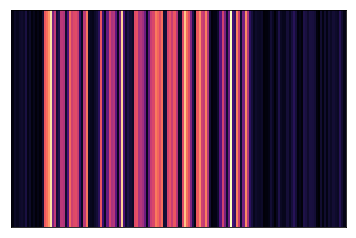

In [37]:
librosa.display.specshow(mel.T)
plt.show()
#raise Exception

[[' ', 'A', 'F', 'E']]


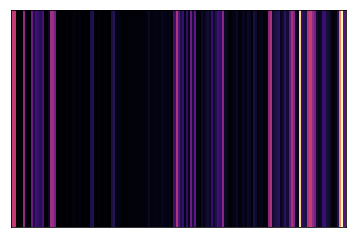

In [35]:
wave, sr = librosa.core.load('/home/user/Downloads/websdr_recording_start_2019-06-15T21_33_16Z_7017.3kHz.wav', sr=8000)
wave = wave[:39936]
mel = get_wave_mel_features(wave)

to_pred = np.zeros([1,  mel_len, mel_count])
to_pred[0,:,:] = mel

print(decode_batch(get_all_layer_outputs, to_pred))

librosa.display.specshow(mel.T)
plt.show()

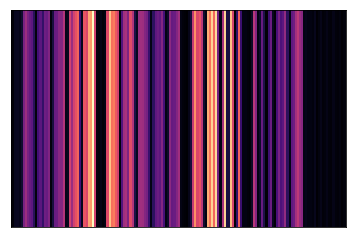

In [23]:
wave, sr = librosa.core.load('/home/user/Dropbox/projs/MorseNet/generated/0.wav', sr=8000)
wave = wave[:39936]
mel = get_wave_mel_features(wave)

to_pred = np.zeros([1,  mel_len, mel_count])
to_pred[0,:,:] = mel

#print(decode_batch(get_all_layer_outputs, to_pred))

librosa.display.specshow(mel.T)
plt.show()